## Import Modules

In [119]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import numpy as np
from scipy.signal import hilbert
import gammatone.filters
from gammatone.gtgram import gtgram
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam


## Load the Dataset

In [2]:
emotion_map = {
    '01': 'Netral',
    '02': 'Senang',
    '03': 'Terkejut',
    '04': 'Jijik',
    '05': 'Kecewa'
}

In [3]:
paths = []
actors = []
genders = []
emotions = []
intensities = []
repetitions = []

base_dir = 'dataset/IndoWaveSentiment/'
for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                paths.append(os.path.join(actor_path, filename))
                parts = filename.replace('.wav', '').split('-')
                actor = parts[0]
                emotion = parts[1]
                intensity = parts[2]
                repetition = parts[3]
                actors.append(actor)
                genders.append('Pria' if int(actor) % 2 == 1 else 'Wanita')
                emotions.append(emotion_map[emotion])
                intensities.append('Normal' if intensity == '01' else 'Strong')
                repetitions.append(repetition)

In [4]:
## Create a dataframe
df = pd.DataFrame({
    'path': paths,
    'aktor': actors,
    'gender': genders,
    'emosi': emotions,
    'intensitas': intensities,
    'repetisi': repetitions
})
df.head()

,path,aktor,gender,emosi,intensitas,repetisi
0,dataset/IndoWaveSentiment/Actor_01\01-01-01-01...,01,Pria,Netral,Normal,01
1,dataset/IndoWaveSentiment/Actor_01\01-01-01-02...,01,Pria,Netral,Normal,02
2,dataset/IndoWaveSentiment/Actor_01\01-01-01-03...,01,Pria,Netral,Normal,03
3,dataset/IndoWaveSentiment/Actor_01\01-01-02-01...,01,Pria,Netral,Strong,01
4,dataset/IndoWaveSentiment/Actor_01\01-01-02-02...,01,Pria,Netral,Strong,02


## Feature Extraction

### MFCC

In [5]:
def extract_mfcc(filename, n_mfcc=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

#### DataFrame

In [6]:
X_mfcc = df['path'].apply(lambda x: extract_mfcc(x))
mfcc = np.stack(X_mfcc.values)
X_mfcc

0      [-310.3727, 89.42707, -5.002537, 45.108185, -2...
1      [-293.58374, 96.594345, -6.6026344, 49.63558, ...
2      [-275.0798, 96.307755, -5.3895497, 52.651905, ...
3      [-300.9955, 86.69134, -4.7884502, 37.07431, -2...
4      [-296.57416, 97.53068, -4.8118505, 43.048214, ...
                             ...                        
295    [-322.98322, 84.86375, 4.3241076, 36.054813, -...
296    [-315.5319, 84.19446, 0.0055141924, 33.952553,...
297    [-342.7631, 94.137825, -1.906536, 30.528961, -...
298    [-367.06488, 98.17489, 11.441321, 34.113586, -...
299    [-342.96817, 88.019485, 0.50365645, 33.983727,...
Name: path, Length: 300, dtype: object

In [7]:
mfcc = [x for x in X_mfcc]
mfcc = np.array(mfcc)
mfcc.shape 

(300, 40)

In [8]:
## input split
mfcc = np.expand_dims(mfcc, -1)
mfcc.shape

(300, 40, 1)

### Multispektrum Hilbert

In [9]:
def extract_hilbert_spectrum(filename, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    analytic_signal = hilbert(y)
    envelope = np.abs(analytic_signal)
    spectrum = np.abs(np.fft.fft(envelope))
    spectrum = spectrum[:len(spectrum)//2]  # Ambil separuh (nyquist)
    # 15 statistik fitur dari envelope/spectrum
    features = [
        np.mean(envelope),
        np.std(envelope),
        np.max(envelope),
        np.min(envelope),
        np.median(envelope),
        np.percentile(envelope, 25),
        np.percentile(envelope, 75),
        np.mean(spectrum),
        np.std(spectrum),
        np.max(spectrum),
        np.min(spectrum),
        np.median(spectrum),
        np.percentile(spectrum, 25),
        np.percentile(spectrum, 75),
        np.sum(envelope**2)  # energy
    ]
    return np.array(features)  # shape: (15,)

#### DataFrame

In [10]:
X_hilbert_spectrum = df['path'].apply(lambda x: extract_hilbert_spectrum(x))
hilbert_spectrum = np.stack(X_hilbert_spectrum.values)
X_hilbert_spectrum

0      [0.09354490786790848, 0.14071166515350342, 1.1...
1      [0.10645010322332382, 0.14868754148483276, 1.2...
2      [0.11742860823869705, 0.1643792986869812, 1.17...
3      [0.10615934431552887, 0.15599283576011658, 1.3...
4      [0.1034325584769249, 0.14503887295722961, 1.09...
                             ...                        
295    [0.13537363708019257, 0.14154790341854095, 1.0...
296    [0.14503295719623566, 0.14839957654476166, 1.2...
297    [0.12333542108535767, 0.12206174433231354, 0.4...
298    [0.10406363010406494, 0.10466554015874863, 0.4...
299    [0.12454231083393097, 0.12590137124061584, 0.5...
Name: path, Length: 300, dtype: object

In [11]:
hilbert_spectrum = [x for x in X_hilbert_spectrum]
hilbert_spectrum = np.array(hilbert_spectrum)
hilbert_spectrum.shape

(300, 15)

In [12]:
## input split
hilbert_spectrum = np.expand_dims(hilbert_spectrum, -1)
hilbert_spectrum.shape

(300, 15, 1)

### Cochleagram

In [13]:
def extract_cochleagram(filename, n_bands=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    # Parameter gtgram: (signal, fs, window_time, hop_time, channels, f_min)
    window_time = 0.025  # 25 ms window
    hop_time = 0.010     # 10 ms hop
    f_min = 50           # Minimum frequency
    # gtgram menghasilkan matriks (n_bands, n_frames)
    cochleagram = gtgram(y, sr, window_time, hop_time, n_bands, f_min)
    # Ambil rata-rata per band (axis=1) untuk vektor fitur
    cochleagram_features = np.mean(cochleagram, axis=1)
    
    return cochleagram_features    

#### DataFrame

In [14]:
X_cochleagram = df['path'].apply(lambda x: extract_cochleagram(x))
cochleagram = np.stack(X_cochleagram.values)
X_cochleagram

0      [0.0005457932336173398, 0.0024897357673786466,...
1      [0.0006170102994991779, 0.002960471769311592, ...
2      [0.000684701532745724, 0.0032143317306341677, ...
3      [0.0008232640771210891, 0.0021796810543438776,...
4      [0.0007159399233960925, 0.002376610643315366, ...
                             ...                        
295    [0.0003233654224053848, 0.0007264485836519567,...
296    [0.00033681808910627906, 0.0007365669055040537...
297    [0.00014938951975930443, 0.0003301573827922905...
298    [0.00015108883794417023, 0.0003317740607166440...
299    [0.0001956450387799354, 0.00035289785049624084...
Name: path, Length: 300, dtype: object

In [15]:
cochleagram = [x for x in X_cochleagram]
cochleagram = np.array(cochleagram)
cochleagram.shape 

(300, 40)

In [16]:
## input split
cochleagram = np.expand_dims(cochleagram, -1)
cochleagram.shape

(300, 40, 1)

### Menggabungkan semua fitur

In [17]:
# Gabungkan Fitur dengan Konsisten cochleagram_flat
def extract_hybrid_features(filename):
    mfcc = extract_mfcc(filename)  # (40,)
    hilbert = extract_hilbert_spectrum(filename)  # (15,)
    cochleagram = extract_cochleagram(filename)  # (64, 192)
    return np.concatenate([mfcc, hilbert, cochleagram])

#### DataFrame

In [18]:
X_hybrid = df['path'].apply(lambda x: extract_hybrid_features(x))
hybrid = np.stack(X_hybrid.values)
print(hybrid.shape)

(300, 95)


In [19]:
hybrid = np.expand_dims(hybrid, -1)
print(hybrid.shape)

(300, 95, 1)


## Encoding Label Emosi

In [120]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['emosi']])

In [121]:
y = y.toarray()
y.shape

(300, 5)

## Scaler

In [123]:
scaler = MinMaxScaler()
hybrid_scaled = scaler.fit_transform(hybrid.reshape(hybrid.shape[0], -1))
hybrid_scaled

array([[0.57511526, 0.46515923, 0.69448393, ..., 0.18141552, 0.19598425,
        0.25133351],
       [0.67063311, 0.56200957, 0.67076353, ..., 0.41747098, 0.42567847,
        0.43028684],
       [0.77590796, 0.55813691, 0.68874671, ..., 0.37713276, 0.3972059 ,
        0.44687351],
       ...,
       [0.39083597, 0.52881497, 0.7403801 , ..., 0.17666011, 0.28263061,
        0.37892224],
       [0.25257528, 0.58336723, 0.93825328, ..., 0.07758723, 0.15238372,
        0.23951547],
       [0.38966921, 0.44613874, 0.77610961, ..., 0.19623464, 0.28089307,
        0.38001961]])

In [116]:
hybrid_scaled = np.expand_dims(hybrid_scaled, axis=-1)
hybrid_scaled

array([[[[0.57511526]],

        [[0.46515923]],

        [[0.69448393]],

        ...,

        [[0.18141552]],

        [[0.19598425]],

        [[0.25133351]]],


       [[[0.67063311]],

        [[0.56200957]],

        [[0.67076353]],

        ...,

        [[0.41747098]],

        [[0.42567847]],

        [[0.43028684]]],


       [[[0.77590796]],

        [[0.55813691]],

        [[0.68874671]],

        ...,

        [[0.37713276]],

        [[0.3972059 ]],

        [[0.44687351]]],


       ...,


       [[[0.39083597]],

        [[0.52881497]],

        [[0.7403801 ]],

        ...,

        [[0.17666011]],

        [[0.28263061]],

        [[0.37892224]]],


       [[[0.25257528]],

        [[0.58336723]],

        [[0.93825328]],

        ...,

        [[0.07758723]],

        [[0.15238372]],

        [[0.23951547]]],


       [[[0.38966921]],

        [[0.44613874]],

        [[0.77610961]],

        ...,

        [[0.19623464]],

        [[0.28089307]],

        [[0.38001

In [117]:
hybrid_scaled.shape

(300, 95, 1, 1)

In [124]:
# Split data hybrid_scaled
X_train, X_test, y_train, y_test = train_test_split(hybrid_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Model CNN

In [125]:
input_shape = (hybrid_scaled.shape[1], 1)

model_cnn = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),                 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 256)           1536      
                                                                 
 batch_normalization_78 (Ba  (None, 91, 256)           1024      
 tchNormalization)                                               
                                                                 
 max_pooling1d (MaxPooling1  (None, 45, 256)           0         
 D)                                                              
                                                                 
 dropout_128 (Dropout)       (None, 45, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 128)           98432     
                                                                 
 batch_normalization_79 (Ba  (None, 43, 128)         

In [126]:
# Training
history_cnn = model_cnn.fit(hybrid_scaled, y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 12s 412ms/step - loss: 2.1918 - accuracy: 0.3042 - val_loss: 1.5977 - val_accuracy: 0.3833
Epoch 2/50
8/8 [==============================] - 2s 212ms/step - loss: 1.5652 - accuracy: 0.3792 - val_loss: 1.5945 - val_accuracy: 0.4167
Epoch 3/50
8/8 [==============================] - 1s 175ms/step - loss: 1.4089 - accuracy: 0.4958 - val_loss: 1.5869 - val_accuracy: 0.3000
Epoch 4/50
8/8 [==============================] - 5s 690ms/step - loss: 1.2482 - accuracy: 0.4792 - val_loss: 1.5983 - val_accuracy: 0.2333
Epoch 5/50
8/8 [==============================] - 4s 465ms/step - loss: 1.0674 - accuracy: 0.5625 - val_loss: 1.6227 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 3s 328ms/step - loss: 1.0608 - accuracy: 0.5750 - val_loss: 1.6689 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 3s 332ms/step - loss: 0.9300 - accuracy: 0.6417 - val_loss: 1.7218 - val_accuracy: 0.2000
Epoch 8/50
8/8 [===

In [127]:
# Training
history_cnn_split = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 3s 356ms/step - loss: 0.5412 - accuracy: 0.8667 - val_loss: 2.3928 - val_accuracy: 0.4833
Epoch 2/50
8/8 [==============================] - 3s 329ms/step - loss: 0.3053 - accuracy: 0.9042 - val_loss: 2.0071 - val_accuracy: 0.5333
Epoch 3/50
8/8 [==============================] - 3s 322ms/step - loss: 0.3095 - accuracy: 0.9125 - val_loss: 1.6739 - val_accuracy: 0.5833
Epoch 4/50
8/8 [==============================] - 3s 320ms/step - loss: 0.2766 - accuracy: 0.8750 - val_loss: 1.7008 - val_accuracy: 0.5833
Epoch 5/50
8/8 [==============================] - 3s 321ms/step - loss: 0.3087 - accuracy: 0.8833 - val_loss: 1.8201 - val_accuracy: 0.5667
Epoch 6/50
8/8 [==============================] - 3s 318ms/step - loss: 0.1710 - accuracy: 0.9250 - val_loss: 1.8193 - val_accuracy: 0.6000
Epoch 7/50
8/8 [==============================] - 3s 336ms/step - loss: 0.1811 - accuracy: 0.9292 - val_loss: 1.7341 - val_accuracy: 0.6333
Epoch 8/50
8/8 [====

In [128]:
# Simpan model yang telah dilatih
model_cnn.save('dataset/model_cnn.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN

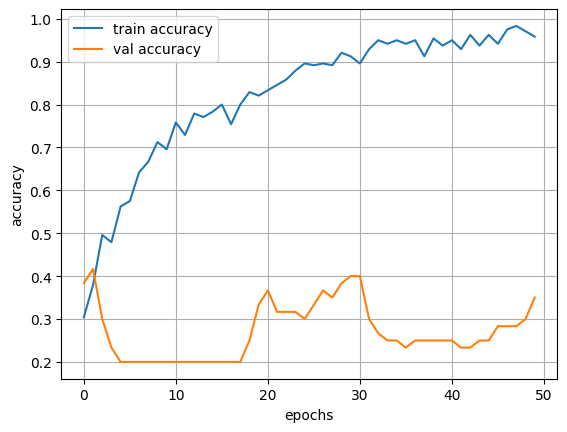

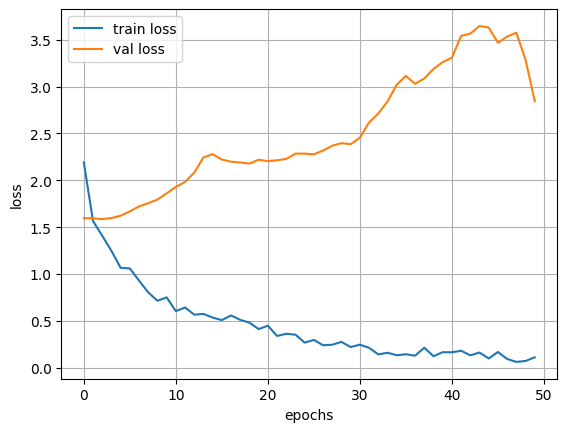

In [131]:
epochs = list(range(len(history_cnn.history['accuracy'])))
plt.plot(epochs, history_cnn.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_cnn.history['loss'], label='train loss')
plt.plot(epochs, history_cnn.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

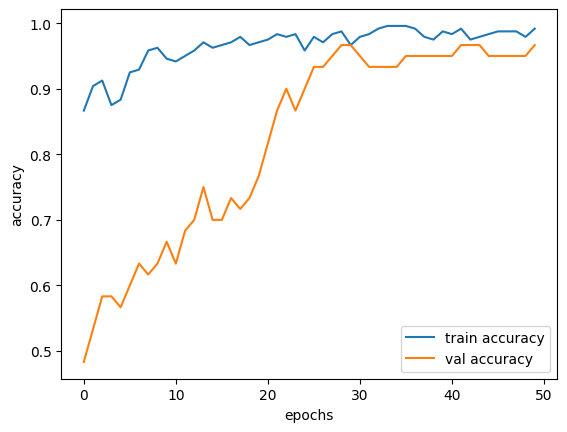

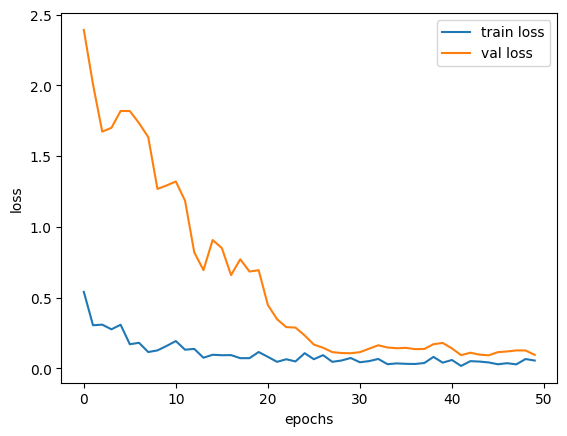

In [132]:
epochs = list(range(len(history_cnn_split.history['accuracy'])))
plt.plot(epochs, history_cnn_split.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn_split.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_cnn_split.history['loss'], label='train loss')
plt.plot(epochs, history_cnn_split.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi CNN

In [133]:
# Prediksi
y_pred_proba_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)
y_true_cnn = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 30ms/step


### Confusion Matrix CNN

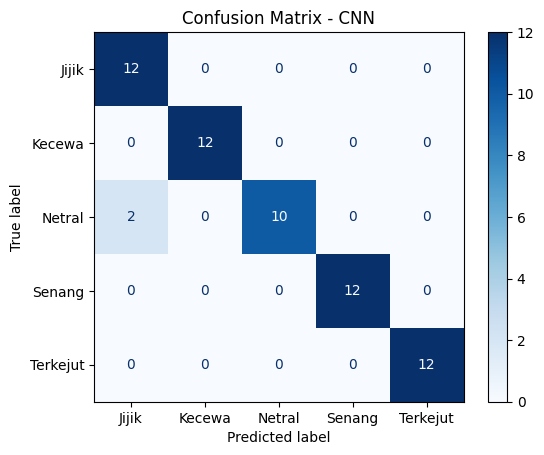

In [134]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics CNN)

In [135]:
print("Akurasi CNN:", accuracy_score(y_true_cnn, y_pred_cnn))
print("Precision (macro):", precision_score(y_true_cnn, y_pred_cnn, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn, y_pred_cnn, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn, y_pred_cnn, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn, y_pred_cnn, target_names=labels))

Akurasi CNN: 0.9666666666666667
Precision (macro): 0.9714285714285715
Recall (macro): 0.9666666666666668
F1-score (macro): 0.9664335664335664

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.86      1.00      0.92        12
      Kecewa       1.00      1.00      1.00        12
      Netral       1.00      0.83      0.91        12
      Senang       1.00      1.00      1.00        12
    Terkejut       1.00      1.00      1.00        12

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



### AUC-ROC CNN

In [136]:
auc_roc_cnn = roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) CNN:", auc_roc_cnn)

AUC-ROC (macro, ovr) CNN: 1.0


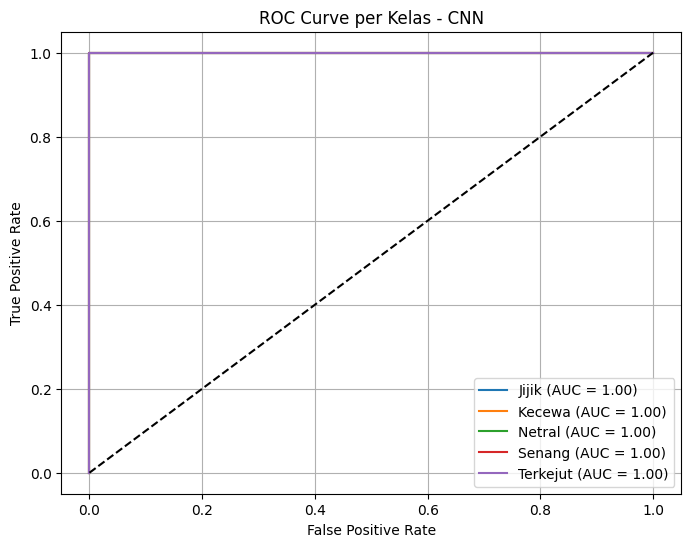

In [137]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_cnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN')
plt.legend()
plt.grid(True)
plt.show()

## Model LSTM

In [ ]:
input_shape = (hybrid_scaled.shape[1], 1)

model_lstm = Sequential([
    LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(64, return_sequences=False, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 95, 128)           66560     
                                                                 
 batch_normalization_111 (B  (None, 95, 128)           512       
 atchNormalization)                                              
                                                                 
 dropout_176 (Dropout)       (None, 95, 128)           0         
                                                                 
 lstm_89 (LSTM)              (None, 64)                49408     
                                                                 
 batch_normalization_112 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 dropout_177 (Dropout)       (None, 64)              

In [ ]:
# Training
history_lstm = model_lstm.fit(hybrid_scaled, y, validation_split=0.2, epochs=100, batch_size=16)

In [147]:
# Training
history_lstm_split = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16)

Epoch 1/100
15/15 [==============================] - 10s 694ms/step - loss: 1.0497 - accuracy: 0.6167 - val_loss: 0.8443 - val_accuracy: 0.6000
Epoch 2/100
15/15 [==============================] - 11s 711ms/step - loss: 0.8973 - accuracy: 0.6083 - val_loss: 0.8256 - val_accuracy: 0.6000
Epoch 3/100
15/15 [==============================] - 10s 681ms/step - loss: 0.9389 - accuracy: 0.6083 - val_loss: 0.8968 - val_accuracy: 0.5833
Epoch 4/100
15/15 [==============================] - 10s 690ms/step - loss: 0.9407 - accuracy: 0.6417 - val_loss: 0.8546 - val_accuracy: 0.5833
Epoch 5/100
15/15 [==============================] - 10s 663ms/step - loss: 0.8480 - accuracy: 0.6417 - val_loss: 0.9515 - val_accuracy: 0.6167
Epoch 6/100
15/15 [==============================] - 10s 652ms/step - loss: 0.9661 - accuracy: 0.6250 - val_loss: 1.1988 - val_accuracy: 0.5500
Epoch 7/100
15/15 [==============================] - 9s 633ms/step - loss: 0.9005 - accuracy: 0.6167 - val_loss: 0.9918 - val_accuracy: 

In [148]:
# Training
history_lstm1 = model_lstm.fit(hybrid_scaled, y, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
4/4 [==============================] - 27s 2s/step - loss: 0.4378 - accuracy: 0.8708 - val_loss: 0.0715 - val_accuracy: 0.9833
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 0.4268 - accuracy: 0.8792 - val_loss: 0.0459 - val_accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 0.3910 - accuracy: 0.8417 - val_loss: 0.0547 - val_accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 0.3320 - accuracy: 0.8792 - val_loss: 0.0538 - val_accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 8s 2s/step - loss: 0.3083 - accuracy: 0.8833 - val_loss: 0.0467 - val_accuracy: 0.9833
Epoch 6/100
4/4 [==============================] - 8s 2s/step - loss: 0.2642 - accuracy: 0.9083 - val_loss: 0.0441 - val_accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 0.2240 - accuracy: 0.9292 - val_loss: 0.0526 - val_accuracy: 1.0000
Epoch 8/100
4/4 [================

In [149]:
# Training
history_lstm_split1 = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)

Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 0.0763 - accuracy: 0.9750 - val_loss: 0.0536 - val_accuracy: 0.9833
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 0.0716 - accuracy: 0.9875 - val_loss: 0.0969 - val_accuracy: 0.9667
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 0.0847 - accuracy: 0.9792 - val_loss: 0.1400 - val_accuracy: 0.9500
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 0.1123 - accuracy: 0.9458 - val_loss: 0.1591 - val_accuracy: 0.9500
Epoch 5/100
4/4 [==============================] - 8s 2s/step - loss: 0.0554 - accuracy: 0.9833 - val_loss: 0.1273 - val_accuracy: 0.9667
Epoch 6/100
4/4 [==============================] - 8s 2s/step - loss: 0.0723 - accuracy: 0.9792 - val_loss: 0.0758 - val_accuracy: 0.9667
Epoch 7/100
4/4 [==============================] - 8s 2s/step - loss: 0.0354 - accuracy: 0.9917 - val_loss: 0.0898 - val_accuracy: 0.9667
Epoch 8/100
4/4 [=================

In [152]:
# Simpan model yang telah dilatih
model_lstm.save('dataset/model_LSTM.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM

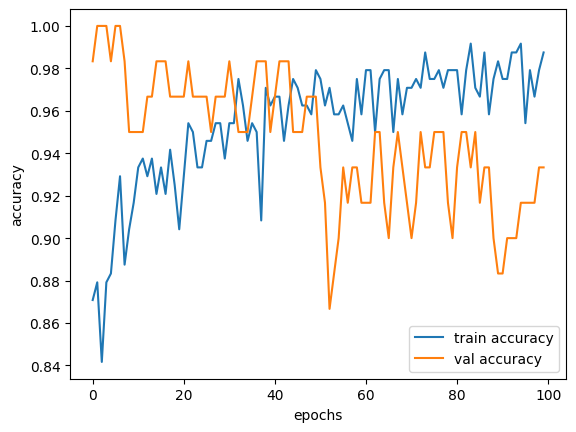

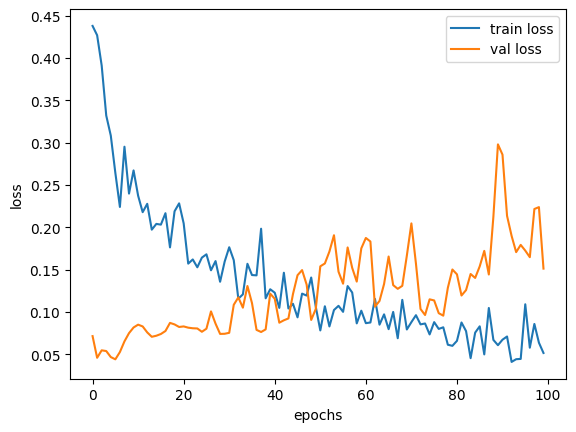

In [154]:
epochs = list(range(len(history_lstm1.history['accuracy'])))
plt.plot(epochs, history_lstm1.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm1.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_lstm1.history['loss'], label='train loss')
plt.plot(epochs, history_lstm1.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

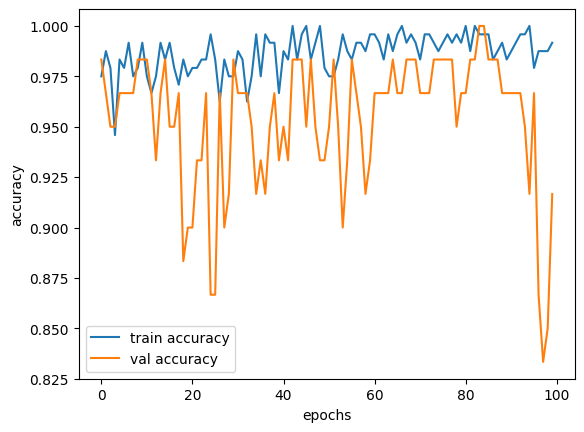

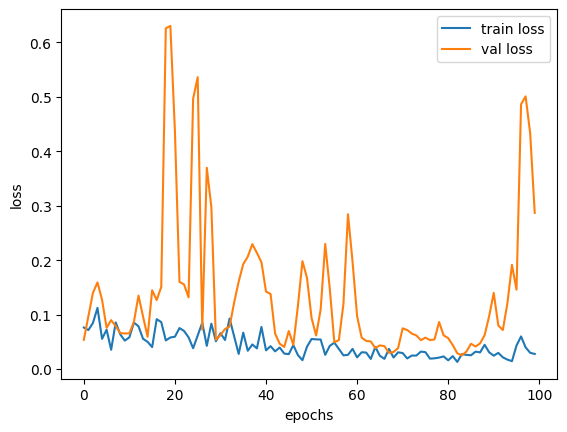

In [155]:
epochs = list(range(len(history_lstm_split1.history['accuracy'])))
plt.plot(epochs, history_lstm_split1.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm_split1.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_lstm_split1.history['loss'], label='train loss')
plt.plot(epochs, history_lstm_split1.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Ambil nilai akurasi dan loss dari history
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history.get('val_accuracy')
loss = history_lstm.history['loss']
val_loss = history_lstm.history.get('val_loss')

# Hitung jumlah epoch
epochs = range(1, len(acc) + 1)

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
if val_acc is not None:
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluasi LSTM

In [157]:
# Prediksi
y_pred_proba_lstm = model_lstm.predict(X_test)
y_pred_lstm = np.argmax(y_pred_proba_lstm, axis=1)
y_true_lstm = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 248ms/step


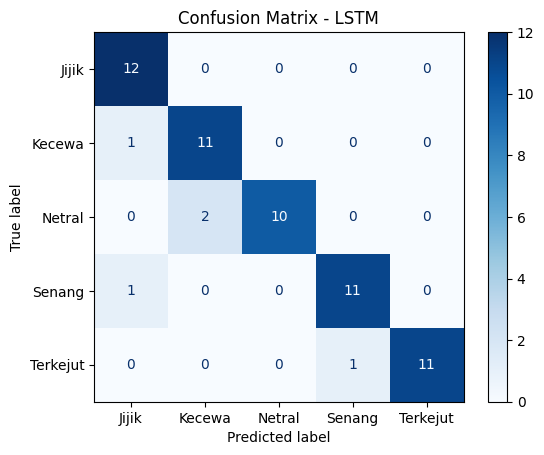

In [158]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_lstm, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics LSTM)

In [159]:
print("Akurasi LSTM:", accuracy_score(y_true_lstm, y_pred_lstm))
print("Precision (macro):", precision_score(y_true_lstm, y_pred_lstm, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm, y_pred_lstm, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm, y_pred_lstm, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm, y_pred_lstm, target_names=labels))

Akurasi LSTM: 0.9166666666666666
Precision (macro): 0.923992673992674
Recall (macro): 0.9166666666666666
F1-score (macro): 0.9170712475929866

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.86      1.00      0.92        12
      Kecewa       0.85      0.92      0.88        12
      Netral       1.00      0.83      0.91        12
      Senang       0.92      0.92      0.92        12
    Terkejut       1.00      0.92      0.96        12

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



### AUC-ROC LSTM

In [160]:
auc_roc_lstm = roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) LSTM:", auc_roc_lstm)

AUC-ROC (macro, ovr) LSTM: 0.9954861111111111


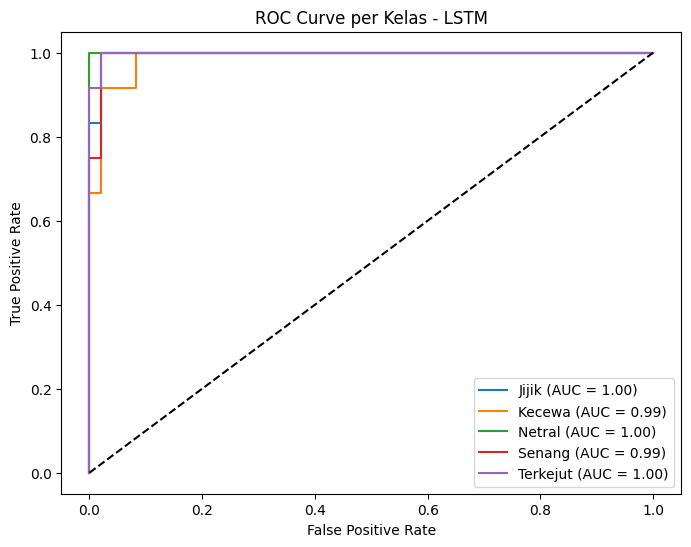

In [161]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_lstm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM')
plt.legend()
plt.show()

## Model CNN + LSTM

In [ ]:
input_shape = (hybrid_scaled.shape[1], 1)

model_hybrid1 = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),                 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_hybrid1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hybrid1.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 95, 256)           1536      
                                                                 
 batch_normalization_102 (B  (None, 95, 256)           1024      
 atchNormalization)                                              
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 47, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_164 (Dropout)       (None, 47, 256)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 45, 128)           98432     
                                                                 
 batch_normalization_103 (B  (None, 45, 128)         

In [ ]:
input_shape = (hybrid_scaled.shape[1], 1)

model_hybrid2 = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(128, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(64, return_sequences=False, activation='tanh'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),   
    BatchNormalization(),              
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_hybrid2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hybrid2.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 95, 256)           1536      
                                                                 
 batch_normalization_106 (B  (None, 95, 256)           1024      
 atchNormalization)                                              
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 47, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_170 (Dropout)       (None, 47, 256)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 45, 128)           98432     
                                                                 
 batch_normalization_107 (B  (None, 45, 128)         

In [ ]:
history_hybrid1 = model_hybrid1.fit(hybrid_scaled, y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 43s 1s/step - loss: 2.1759 - accuracy: 0.2625 - val_loss: 1.6070 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 5s 610ms/step - loss: 1.9449 - accuracy: 0.2583 - val_loss: 1.6007 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 5s 618ms/step - loss: 1.6596 - accuracy: 0.3375 - val_loss: 1.6084 - val_accuracy: 0.3000
Epoch 4/50
8/8 [==============================] - 5s 620ms/step - loss: 1.6978 - accuracy: 0.3208 - val_loss: 1.6138 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 5s 633ms/step - loss: 1.6874 - accuracy: 0.3292 - val_loss: 1.6281 - val_accuracy: 0.2167
Epoch 6/50
8/8 [==============================] - 5s 624ms/step - loss: 1.5434 - accuracy: 0.3833 - val_loss: 1.6370 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 5s 634ms/step - loss: 1.5262 - accuracy: 0.3750 - val_loss: 1.6580 - val_accuracy: 0.2000
Epoch 8/50
8/8 [======

In [ ]:
history_hybrid_split1 = model_hybrid1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 3s 382ms/step - loss: 0.6893 - accuracy: 0.7917 - val_loss: 0.8412 - val_accuracy: 0.7000
Epoch 2/50
8/8 [==============================] - 3s 367ms/step - loss: 0.6598 - accuracy: 0.7500 - val_loss: 0.8718 - val_accuracy: 0.6667
Epoch 3/50
8/8 [==============================] - 3s 344ms/step - loss: 0.6432 - accuracy: 0.7833 - val_loss: 1.0133 - val_accuracy: 0.6333
Epoch 4/50
8/8 [==============================] - 3s 345ms/step - loss: 0.5264 - accuracy: 0.7833 - val_loss: 0.8599 - val_accuracy: 0.7000
Epoch 5/50
8/8 [==============================] - 3s 390ms/step - loss: 0.4301 - accuracy: 0.8500 - val_loss: 0.7164 - val_accuracy: 0.6667
Epoch 6/50
8/8 [==============================] - 4s 492ms/step - loss: 0.4649 - accuracy: 0.8333 - val_loss: 0.6739 - val_accuracy: 0.7000
Epoch 7/50
8/8 [==============================] - 5s 606ms/step - loss: 0.4263 - accuracy: 0.8458 - val_loss: 0.6406 - val_accuracy: 0.7500
Epoch 8/50
8/8 [====

In [173]:
# Simpan model yang telah dilatih
model_hybrid.save('dataset/model_hybrid.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi Hybrid

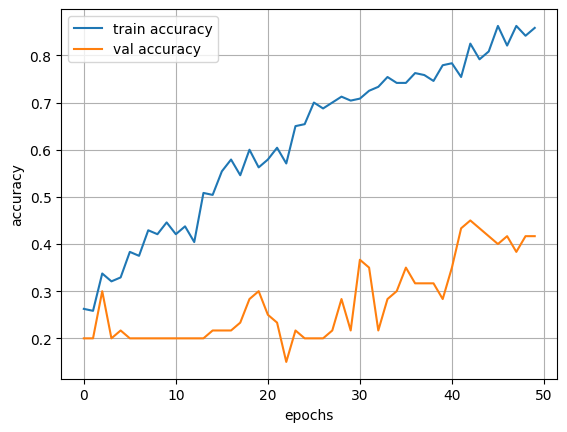

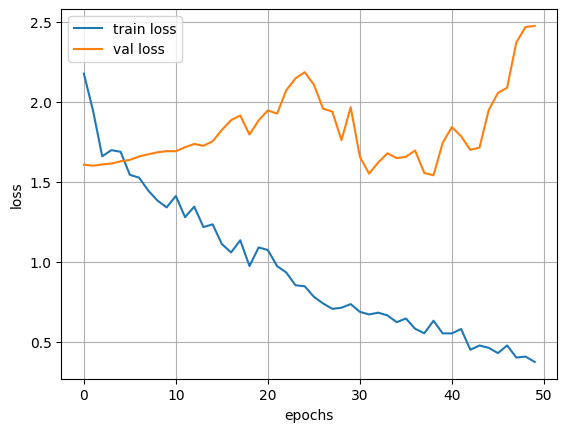

In [174]:
epochs = list(range(len(history_hybrid.history['accuracy'])))
plt.plot(epochs, history_hybrid.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_hybrid.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, history_hybrid.history['loss'], label='train loss')
plt.plot(epochs, history_hybrid.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

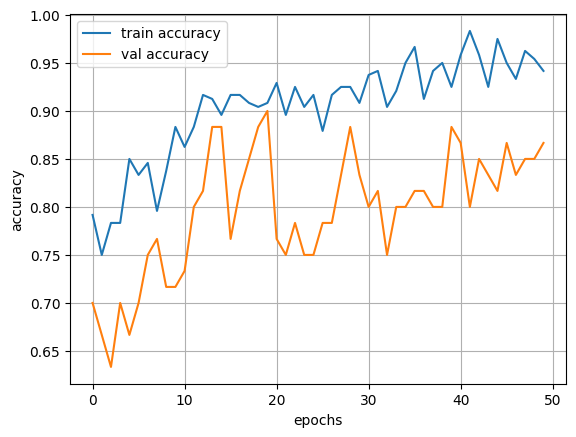

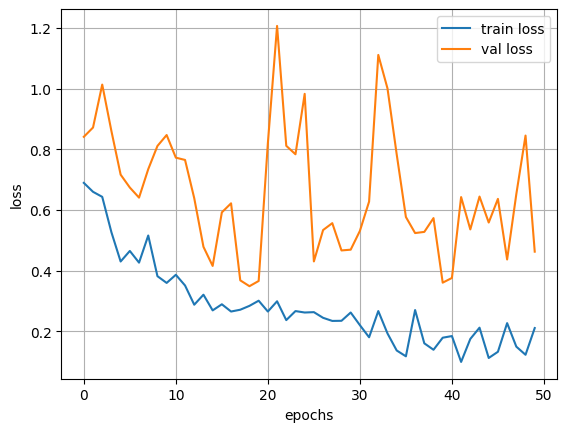

In [175]:
epochs = list(range(len(history_hybrid_split.history['accuracy'])))
plt.plot(epochs, history_hybrid_split.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_hybrid_split.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, history_hybrid_split.history['loss'], label='train loss')
plt.plot(epochs, history_hybrid_split.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi Hybrid

In [177]:
# Prediksi
y_pred_proba_hybrid = model_hybrid.predict(X_test)
y_pred_hybrid = np.argmax(y_pred_proba_hybrid, axis=1)
y_true_hybrid = np.argmax(y_test, axis=1)

2/2 [==============================] - 1s 479ms/step


### Confusion Matrix Hybrid

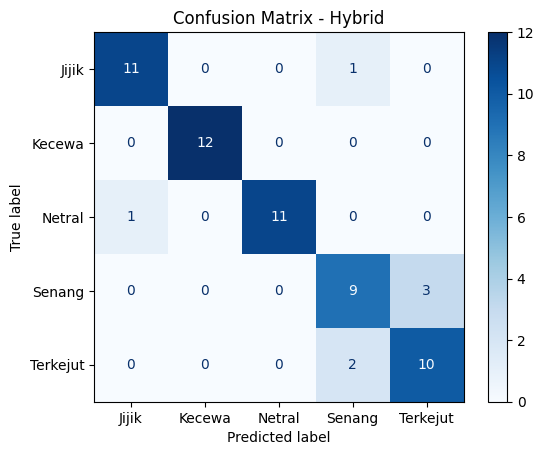

In [192]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_hybrid, y_pred_hybrid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Hybrid')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics Hybrid)

In [179]:
print("Akurasi Hybrid:", accuracy_score(y_true_hybrid, y_pred_hybrid))
print("Precision (macro):", precision_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("Recall (macro):", recall_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("F1-score (macro):", f1_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_hybrid, y_pred_hybrid, target_names=labels))

Akurasi Hybrid: 0.8833333333333333
Precision (macro): 0.8871794871794872
Recall (macro): 0.8833333333333332
F1-score (macro): 0.8846376811594203

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.92      0.92      0.92        12
      Kecewa       1.00      1.00      1.00        12
      Netral       1.00      0.92      0.96        12
      Senang       0.75      0.75      0.75        12
    Terkejut       0.77      0.83      0.80        12

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



### AUC-ROC Hybrid CNN + LSTM

In [181]:
auc_roc_hybrid = roc_auc_score(y_test, y_pred_proba_hybrid, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) Hybrid:", auc_roc_hybrid)

AUC-ROC (macro, ovr) Hybrid: 0.9913194444444444


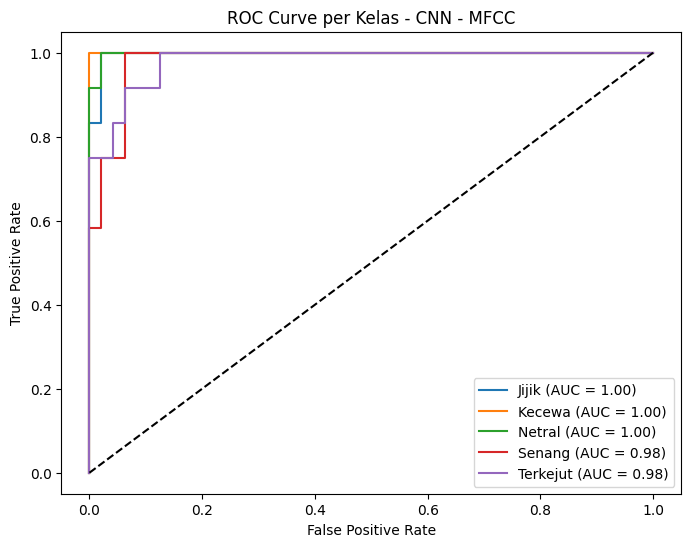

In [183]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN - MFCC')
plt.legend()
plt.show()

# Perbandingan Kinerja antar Model

In [195]:
# Kumpulkan semua metrik ke dalam dictionary
metrics_data = {
    'Model': ['CNN', 'LSTM', 'Hybrid (CNN+LSTM)'],
    'Akurasi': [
        accuracy_score(y_true_cnn, y_pred_cnn),
        accuracy_score(y_true_lstm, y_pred_lstm),
        accuracy_score(y_true_hybrid, y_pred_hybrid)
    ],
    'Precision (macro)': [
        precision_score(y_true_cnn, y_pred_cnn, average='macro'),
        precision_score(y_true_lstm, y_pred_lstm, average='macro'),
        precision_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_true_cnn, y_pred_cnn, average='macro'),
        recall_score(y_true_lstm, y_pred_lstm, average='macro'),
        recall_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'F1-score (macro)': [
        f1_score(y_true_cnn, y_pred_cnn, average='macro'),
        f1_score(y_true_lstm, y_pred_lstm, average='macro'),
        f1_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'AUC-ROC (macro)': [
        roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_hybrid, average='macro', multi_class='ovr')
    ]
}

# Buat DataFrame
comparison_df = pd.DataFrame(metrics_data)
print("Tabel Perbandingan Kinerja Model:")
print(comparison_df.to_string())

Tabel Perbandingan Kinerja Model:
               Model   Akurasi  Precision (macro)  Recall (macro)  F1-score (macro)  AUC-ROC (macro)
0                CNN  0.966667           0.971429        0.966667          0.966434         1.000000
1               LSTM  0.916667           0.923993        0.916667          0.917071         0.995486
2  Hybrid (CNN+LSTM)  0.883333           0.887179        0.883333          0.884638         0.991319


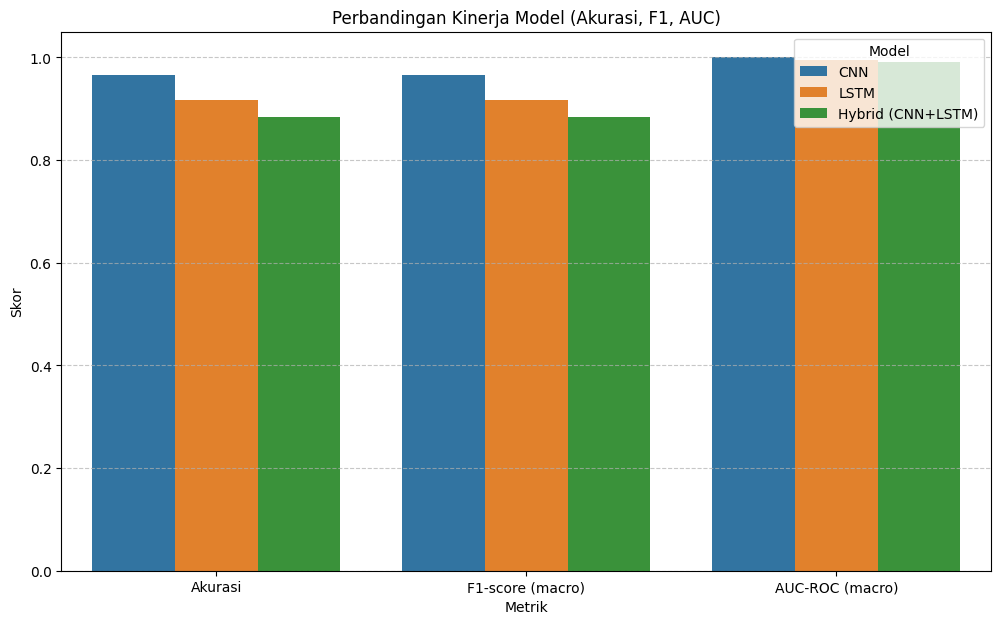

In [196]:
# Siapkan data untuk plot
plot_df = comparison_df.melt(id_vars='Model', value_vars=['Akurasi', 'F1-score (macro)', 'AUC-ROC (macro)'],
                             var_name='Metrik', value_name='Skor')

# Buat bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df, x='Metrik', y='Skor', hue='Model')
plt.title('Perbandingan Kinerja Model (Akurasi, F1, AUC)')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [187]:
# Siapkan probabilitas dari setiap model
models_proba = {
    'CNN': y_pred_proba_cnn,
    'LSTM': y_pred_proba_lstm,
    'Hybrid (CNN+LSTM)': y_pred_proba_hybrid
}

plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

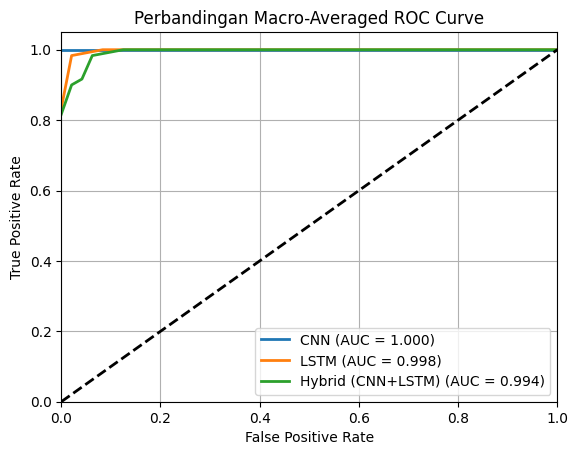

In [188]:
# Loop untuk setiap model
for model_name, y_pred_proba in models_proba.items():
    # Hitung macro-average ROC
    n_classes = y_test.shape[1]
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'{model_name} (AUC = {macro_auc:.3f})',
             linewidth=2)

# Plot garis referensi
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan Macro-Averaged ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()